In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

!pip install --q japanize_matplotlib
import japanize_matplotlib

%matplotlib inline
plt.style.use("ggplot")

! pip install --q plotly
import plotly.graph_objects as go
import plotly.express as px

from sklearn.metrics import mean_squared_error


from google.cloud import bigquery
# プロジェクトIDの指定
project_id = 'inunaki'
# authが終わっていたら普通にクライアント認証は通る
client = bigquery.Client(project=project_id)

import warnings
warnings.simplefilter('ignore')


ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: '/opt/conda/etc/jupyter/nbconfig/notebook.d/jupyterlab-plotly.json'
Consider using the `--user` option or check the permissions.



In [2]:
query = """
-- 前日のみ更新するためにコードを書く
CREATE TEMPORARY FUNCTION to_date2() AS (CURRENT_DATE("Asia/Tokyo") - 2);
-- 期間を絞る
CREATE TEMPORARY FUNCTION to_date() AS (DATE(2023, 8, 31));
CREATE TEMPORARY FUNCTION to_date_start_date() AS(DATE(2023, 7, 14));

-- 実際に購入まで行った顧客
WITH base AS(
  SELECT  salesday, COALESCE(customercd_new, posid.customercd) AS customercd, jan, SUM(salesamount)AS sales_amt, SUM(salescnt)AS cnt, salestime, storecd
  FROM `inunaki.dwd_cdp_0001.dwd_cdp_idpos_detail` posid 
  LEFT JOIN `inunaki.dim_common_0001.dim_crm_customer_change_history` ii
  ON posid.customercd = ii.customercd
  WHERE salesday BETWEEN to_date_start_date() AND to_date() 
  AND posid.customercd <> "0"
  GROUP BY salesday, customercd, jan, salestime, storecd
 ),
 tmp_data AS(
  SELECT salesday, salestime, storecd, customercd, CAST(jan AS INT64) jan, sales_amt, cnt
  FROM base 
),
-- janを追加する
result AS(
  SELECT salesday, salestime, storecd, customercd, 
         coupon_name, app_jan.jan, kubun, haisin_tuki, end_tuki, sales_amt, cnt, huyo_point, coupon_id, types
  FROM tmp_data
  -- 抽選は外して出す
  JOIN (SELECT * FROM `inunaki.dst_workspace.app_cupon_jan` WHERE types <> "キャンペーン・クーポン（抽選）" AND types <> "キャンペーン（抽選）" AND kubun = "サマキャン" AND kubun = "サマキャン")  app_jan
  ON tmp_data.jan = app_jan.jan
),
-- アプリクーポン宣言ベースデータ 
app_sengen_base AS(
  SELECT  dt, month, customer_id, sync_dttm, coupon_name, CAST(tmp.coupon_id AS INT64) AS coupon_id, CONCAT(dt, "_", coupon_name) AS coupon_name2
  -- 日付を変更する
  FROM(
  SELECT  DATE(year,month,dt) AS dt, month, customer_id, sync_dttm, coupon_name, CAST(coupon_id AS INT64) AS coupon_id
  FROM `inunaki.dwd_action_0001.dwd_karte_user_use_coupon`
  ) tmp
  -- 抽選は外して出す
  JOIN (SELECT DISTINCT coupon_id FROM `inunaki.dst_workspace.app_cupon_jan` WHERE types <> "キャンペーン・クーポン（抽選）" AND types <> "キャンペーン（抽選）" AND kubun = "サマキャン" AND kubun = "サマキャン")  app_jan
  ON tmp.coupon_id = app_jan.coupon_id
  WHERE dt BETWEEN to_date_start_date() AND to_date()
),
-- 宣言した日もしくは、それ以降に実際に購入した顧客
sengen_konyu AS(
SELECT salesday, salestime, storecd, customercd, sync_dttm, dt,
         result.coupon_name, jan, kubun, haisin_tuki, end_tuki, sales_amt, cnt, huyo_point, types, coupon_name2, 
         CASE
         WHEN (salestime >= sync_dttm) AND (salesday <= end_tuki)THEN 1
         WHEN salesday = dt THEN 1
         ELSE 0 
         END AS riyo_flg,

         CASE
         WHEN types = "一回限り" THEN 1
         ELSE cnt
         END AS coupon_count
FROM result
JOIN app_sengen_base
ON result.customercd = app_sengen_base.customer_id
AND result.coupon_id = app_sengen_base.coupon_id
)
-- 1回のみの使用なのでそれを絞る
SELECT salesday2, result_data.storecd, storename, blockname, store_format_name, 
       EXTRACT(MONTH FROM  DATE (salesday2) ) AS month, customercd, coupon_name2, AVG(huyo_point) AS huyo_point, AVG(coupon_count) AS coupon_count,
FROM(SELECT salesday,FIRST_VALUE(salesday) OVER(PARTITION BY customercd,coupon_name2  ORDER BY salesday) AS salesday2,
            FIRST_VALUE(coupon_count) OVER(PARTITION BY customercd,coupon_name2  ORDER BY salesday) AS coupon_count,
            customercd, coupon_name2,huyo_point ,storecd
      FROM sengen_konyu WHERE riyo_flg = 1) result_data
INNER JOIN `inunaki.dim_common_0001.dim_store` store 
ON result_data.storecd = store.storecd
LEFT JOIN `inunaki.dim_org_0001.dim_branches` a
ON result_data.storecd = a.store_cd
LEFT JOIN `inunaki.dim_org_0001.dim_branch_format` b
ON a.store_format_cd = b.store_format_cd
GROUP BY salesday2, customercd, coupon_name2, storecd, storename, blockname, store_format_name
"""

#データフレームに変換
df_data = client.query(query).to_dataframe()

In [3]:
query = """
-- 前日のみ更新するためにコードを書く
CREATE TEMPORARY FUNCTION to_date2() AS (CURRENT_DATE("Asia/Tokyo") - 2);
-- 期間を絞る
CREATE TEMPORARY FUNCTION to_date() AS (DATE(2023, 8, 31));
CREATE TEMPORARY FUNCTION to_date_start_date() AS(DATE(2023, 7, 14));

-- 来店している顧客を取り出す
WITH base AS (
SELECT  COALESCE(customercd_new, posid.customercd) AS customercd, storecd, COUNT(posno) AS raiten_count
FROM `inunaki.dwd_cdp_0001.dwd_cdp_idpos_header` posid 
LEFT JOIN `inunaki.dim_common_0001.dim_crm_customer_change_history` ii
ON posid.customercd = ii.customercd
WHERE salesday BETWEEN to_date_start_date() AND to_date() 
AND posid.customercd <> "0"
GROUP BY COALESCE(customercd_new, posid.customercd), storecd
),
store_result_data AS (
  SELECT customercd, result_store.storecd, storename, blockname, store_format_name
  FROM (SELECT customercd, storecd, ROW_NUMBER() OVER (PARTITION BY customercd ORDER BY raiten_count DESC) AS row_num FROM base) result_store
  INNER JOIN `inunaki.dim_common_0001.dim_store` store 
  ON result_store.storecd = store.storecd
  LEFT JOIN `inunaki.dim_org_0001.dim_branches` a
  ON result_store.storecd = a.store_cd
  LEFT JOIN `inunaki.dim_org_0001.dim_branch_format` b
  ON a.store_format_cd = b.store_format_cd
  WHERE row_num = 1
),
-- 期間中にホームを一度でも見た顧客
home_view AS(
  SELECT  DISTINCT customer_id
  FROM `inunaki.dwd_action_0001.dwd_karte_supay_accesshome` 
  WHERE DATE(year,month,dt) BETWEEN to_date_start_date() AND to_date() 
)
-- 期間中にホームを一度でも見る AND 来店した顧客
SELECT customercd, storecd, storename, blockname, store_format_name
FROM store_result_data
JOIN home_view
ON store_result_data.customercd = home_view.customer_id
"""

#データフレームに変換
df_cus = client.query(query).to_dataframe()


In [4]:
# 宣言した人数
query = """
  SELECT  DATE(year,month,dt) AS dt, month, customer_id, sync_dttm, coupon_name, CAST(coupon_id AS INT64) AS coupon_id, customercd
  FROM `inunaki.dwd_action_0001.dwd_karte_user_use_coupon` use_coupon
  LEFT JOIN `inunaki.dim_crm_0001.dim_crm_customer_md5` md5_cus
  ON use_coupon.customer_id = md5_cus.customercd_md5
  WHERE DATE(year,month,dt) BETWEEN "2023-07-14" AND "2023-08-31"
"""

#データフレームに変換
df_sengen = client.query(query).to_dataframe()
df_sengen = df_sengen.query("coupon_name!='【テスト】ひんやり敷きパッド_S_約100×205cm'")

In [5]:
df_cus.head()

,customercd,storecd,storename,blockname,store_format_name
0,05e28c25024b4483540151f2ae0c7e85,281,トライウェル那珂店,Ｄ栃木東,SMART
1,06fb3fbe5a8ed0ae4c9e3cdaaf067184,364,名取店,名取,SuC
2,09998e746d44b2e0c5dee24377639499,364,名取店,名取,SuC
3,0e2b5aecaa15d9a53d1f59c3be6ba428,364,名取店,名取,SuC
4,0fd039243f0820e1d8b6304d6667e722,240,トライウェル鉾田店,Ｄ千葉茨城南,SMART


In [6]:
df_data.head()

,salesday2,storecd,storename,blockname,store_format_name,month,customercd,coupon_name2,huyo_point,coupon_count
0,2023-07-24,27,新宮店,福岡,MEGA,7,a03653bd7ac94f5ceb49ce0b144c6eaf,2023-07-24_シーバ_パウチ_[35g/40g]×6袋_各種,40.0,1.0
1,2023-07-29,27,新宮店,福岡,MEGA,7,1bf244ce4a653aadf47bc31565e54600,2023-07-20_ミツカンカンタン酢_1L（セット売り商品は対象外）,50.0,1.0
2,2023-07-28,27,新宮店,福岡,MEGA,7,e60c0db076922737349254bc97e15964,2023-07-27_ミツカン追いがつおつゆ_1L（セット売り商品は対象外）,30.0,1.0
3,2023-07-29,27,新宮店,福岡,MEGA,7,04fa67748bd448c00f5000f5dd264de2,2023-07-29_フィーノ_各種_[ヘアマスク/ヘアオイル],50.0,1.0
4,2023-08-06,27,新宮店,福岡,MEGA,8,67bc28ab915e50e350a3aaaeb060c871,2023-08-06_プチシリーズ_各種,200.0,1.0


In [7]:
# クーポンを1度でも利用した顧客
df_riyo = df_data.groupby(["customercd"]).agg({"coupon_count":"count"}).reset_index()
# どこの店舗で使ったのか？使ってない顧客はどこの店舗なのか？
df_riyo = df_cus.merge(df_riyo,on="customercd",how="left").fillna(0)
# クーポン利用の有無
df_riyo["riyo_flg"] = df_riyo.apply(lambda x:1 if x["coupon_count"]>=1 else 0, axis=1)

In [8]:
df_pivot = df_riyo.groupby(["store_format_name","riyo_flg"]).agg({"customercd":"count"}).reset_index()
df_pivot = pd.pivot_table(df_pivot,index="store_format_name",columns="riyo_flg",values="customercd",aggfunc="sum").reset_index().dropna()
df_pivot = df_pivot.rename(columns={0:"クーポン未利用者",1:"クーポン利用者","store_format_name":"フォーマット名"})
df_pivot["利用率"] = round(df_pivot["クーポン利用者"] / (df_pivot["クーポン未利用者"] + df_pivot["クーポン利用者"]) * 100, 3)

In [9]:
df_pivot.sort_values("利用率",ascending=False)

riyo_flg,フォーマット名,クーポン未利用者,クーポン利用者,利用率
3,SMART,41375.0,742.0,1.762
1,GO,4229.0,74.0,1.720
4,SuC,234011.0,4008.0,1.684
2,MEGA,50362.0,754.0,1.475
5,グロッサリア,68.0,1.0,1.449


In [10]:
# 実際に支払いが行われた店舗を出す
df_riyo = df_data.groupby(["store_format_name"]).agg({"customercd":"count"}).rename(columns={"customercd":"クーポン利用人数"}).reset_index()
# 全体の顧客を出す
df_all_count = df_cus.groupby(["store_format_name"]).agg({"customercd":"count"}).rename(columns={"customercd":"期間中SU-PAY来店ユーザー"}).reset_index()
# 両方をマージする
df_result = df_riyo.merge(df_all_count,on="store_format_name")
df_result["利用率"] = round(df_result["クーポン利用人数"] / df_result["期間中SU-PAY来店ユーザー"] * 100, 2)
df_result = df_result.sort_values("利用率",ascending=False).rename(columns={"store_format_name":"フォーマット名"})
df_result["利用率"] = df_result["利用率"].astype(str) + "%"
df_result = df_result[["フォーマット名","期間中SU-PAY来店ユーザー","クーポン利用人数","利用率"]]

In [11]:
df_result

,フォーマット名,期間中SU-PAY来店ユーザー,クーポン利用人数,利用率
2,SMART,42117,1074,2.55%
3,SuC,238019,5525,2.32%
0,GO,4303,88,2.05%
1,MEGA,51116,1020,2.0%


In [12]:
# 実際に支払いが行われた店舗を出す
df_riyo = df_data.groupby(["blockname"]).agg({"customercd":"count"}).rename(columns={"customercd":"クーポン利用人数"}).reset_index()
# 全体の顧客を出す
df_all_count = df_cus.groupby(["blockname"]).agg({"customercd":"count"}).rename(columns={"customercd":"期間中SU-PAY来店ユーザー"}).reset_index()
# 両方をマージする
df_result = df_riyo.merge(df_all_count,on="blockname")
df_result["利用率"] = round(df_result["クーポン利用人数"] / df_result["期間中SU-PAY来店ユーザー"] * 100, 2)
df_result = df_result.sort_values("利用率",ascending=False).rename(columns={"blockname":"ブロック名"})
df_result["利用率"] = df_result["利用率"].astype(str) + "%"

df_count_tenpo = df_cus.groupby(["blockname"]).agg({"storename":"nunique"}).reset_index().rename(columns={"storename":"対象店舗数","blockname":"ブロック名"})
df_result = df_result.merge(df_count_tenpo, on="ブロック名",how="left")

df_result = df_result[["ブロック名","対象店舗数","期間中SU-PAY来店ユーザー","クーポン利用人数","利用率"]]

In [13]:
df_cus.query("blockname=='宮若'")[["storename","store_format_name"]].drop_duplicates()

,storename,store_format_name
59075,小竹店,SuC
59076,宮田店,SuC
59083,鞍手店,SuC
59101,トライウェル目尾店,GO


In [14]:
df_result

,ブロック名,対象店舗数,期間中SU-PAY来店ユーザー,クーポン利用人数,利用率
0,Ｄ栃木西,4,570,31,5.44%
1,Ｄ栃木東,4,798,39,4.89%
2,本部,2,634,21,3.31%
3,宮若,4,4095,135,3.3%
4,群馬埼玉南,8,5023,164,3.26%
5,日向,2,1759,56,3.18%
6,遠賀直鞍,8,11025,342,3.1%
7,山口東,5,6671,189,2.83%
8,小倉,7,12322,344,2.79%
9,京築,6,8788,236,2.69%


In [15]:
# 実際に支払いが行われた店舗を出す
df_riyo = df_data.groupby(["storename","store_format_name"]).agg({"customercd":"count"}).rename(columns={"customercd":"クーポン利用人数"}).reset_index()
# 全体の顧客を出す
df_all_count = df_cus.groupby(["storename","store_format_name"]).agg({"customercd":"count"}).rename(columns={"customercd":"期間中SU-PAY来店ユーザー"}).reset_index()
# 両方をマージする
df_result = df_riyo.merge(df_all_count,on=["storename","store_format_name"])
df_result["利用率"] = round(df_result["クーポン利用人数"] / df_result["期間中SU-PAY来店ユーザー"] * 100, 2)
df_result = df_result.sort_values("利用率",ascending=False).rename(columns={"storename":"店舗名","store_format_name":"フォーマット名"})
# df_result["利用率"] = df_result["利用率"].astype(str) + "%"
df_result = df_result[["店舗名","フォーマット名","期間中SU-PAY来店ユーザー","クーポン利用人数","利用率"]]

In [16]:
df_result.head(20)

,店舗名,フォーマット名,期間中SU-PAY来店ユーザー,クーポン利用人数,利用率
28,トライウェル馬頭店,SMART,97,14,14.43
115,安中店,SMART,481,53,11.02
262,韮崎店,SMART,207,18,8.70
228,茂木店,SMART,103,8,7.77
23,トライウェル矢板店,SMART,142,8,5.63
26,トライウェル野田店,SMART,179,10,5.59
106,太田由良店,SMART,454,25,5.51
211,石田店,SuC,581,31,5.34
13,トライアルクイック多の津店,GO,394,21,5.33
20,トライウェル桜川店,SMART,218,11,5.05


In [17]:
df_result["フォーマット名"].unique()

array(['SMART', 'SuC', 'GO', 'MEGA'], dtype=object)

<AxesSubplot:xlabel='フォーマット名', ylabel='利用率'>

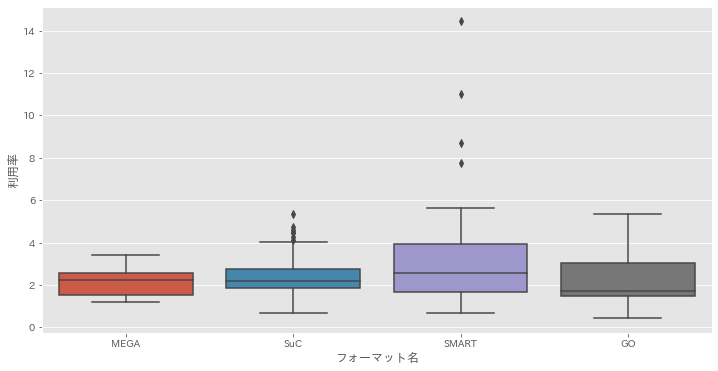

In [18]:
category_order = ['MEGA', 'SuC', 'SMART', 'GO']
plt.figure(figsize=(12,6))
sns.boxplot(x=df_result["フォーマット名"], y=df_result["利用率"], order=category_order)

In [19]:
# フォーマットごとに使われるクーポンが違うのか？
df_tmp = df_data.copy()
df_tmp["coupon_name2"] = df_tmp["coupon_name2"].str.split('_').str.get(1)
df_tmp = df_tmp.groupby(["coupon_name2","store_format_name"]).agg({"customercd":"count"}).reset_index().rename(columns={"customercd":"riyo_count"})

for i in df_tmp["store_format_name"].unique():
    display(df_tmp.query("store_format_name==@i").sort_values("riyo_count",ascending=False).head(10))

,coupon_name2,store_format_name,riyo_count
28,プチシリーズ,GO,46
50,レッドブル,GO,23
39,ミツカン追いがつおつゆ,GO,8
35,ミツカンカンタン酢,GO,3
20,シーブリーズ,GO,2
24,フィーノ,GO,2
0,おすだけアースレッド,GO,1
4,アリエールジェルボール,GO,1
46,ルシードニオイケアシリーズ,GO,1
54,消臭力イオン消臭プラス,GO,1


,coupon_name2,store_format_name,riyo_count
29,プチシリーズ,MEGA,416
40,ミツカン追いがつおつゆ,MEGA,172
51,レッドブル,MEGA,104
25,フィーノ,MEGA,54
36,ミツカンカンタン酢,MEGA,45
32,ボールドジェルボール,MEGA,36
21,シーブリーズ,MEGA,33
5,アリエールジェルボール,MEGA,28
11,ゴミ箱の消臭力,MEGA,28
8,キリン一番搾り糖質ゼロ,MEGA,23


,coupon_name2,store_format_name,riyo_count
30,プチシリーズ,SMART,564
41,ミツカン追いがつおつゆ,SMART,142
52,レッドブル,SMART,90
37,ミツカンカンタン酢,SMART,53
26,フィーノ,SMART,52
33,ボールドジェルボール,SMART,31
56,消臭力イオン消臭プラス,SMART,31
22,シーブリーズ,SMART,30
6,アリエールジェルボール,SMART,23
12,ゴミ箱の消臭力,SMART,19


,coupon_name2,store_format_name,riyo_count
31,プチシリーズ,SuC,2563
42,ミツカン追いがつおつゆ,SuC,807
53,レッドブル,SuC,529
27,フィーノ,SuC,295
38,ミツカンカンタン酢,SuC,295
34,ボールドジェルボール,SuC,154
57,消臭力イオン消臭プラス,SuC,150
23,シーブリーズ,SuC,148
7,アリエールジェルボール,SuC,147
13,ゴミ箱の消臭力,SuC,147


In [20]:
# 計画購買と目的購買を分けてみていくひつようがある。
# 宣言から利用までの時間を見て、どこで使っているかを見つける。(仮説：家というよりも店舗で使っているのではないか？)
#  → 計画購買というより非計画購買によって利用されている可能性が高い。
#クーポンがあるから使っている。
#クーポンファンユーザーはいるのか？

<AxesSubplot:ylabel='Density'>

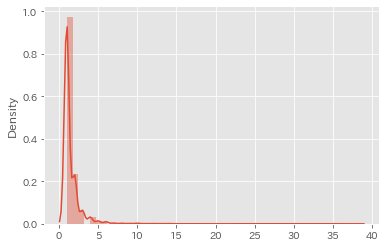

In [21]:
df_tmp = df_data.groupby(["customercd"]).agg({"coupon_count":"sum"})
sns.distplot(df_tmp.query("coupon_count>=1&coupon_count<=50"))

In [22]:
df_tmp.describe()

,coupon_count
count,5594.000000
mean,1.597962
std,2.332415
min,-1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,120.000000


In [23]:
df_tmp2 = df_tmp.reset_index().query("coupon_count>=1").groupby(["coupon_count"]).agg({"customercd":"count"}).sort_values("customercd",ascending=False)
df_tmp2["ratio"] = round(df_tmp2["customercd"] / df_tmp2["customercd"].sum()*100, 2)
df_tmp2["ratio"] = df_tmp2["ratio"].astype(str) + "%"
df_tmp2 = df_tmp2.reset_index()
df_tmp2.sort_values("coupon_count")

,coupon_count,customercd,ratio
0,1.0,4028,72.07%
1,2.0,976,17.46%
2,3.0,269,4.81%
3,4.0,136,2.43%
4,5.0,59,1.06%
5,6.0,43,0.77%
6,7.0,14,0.25%
7,8.0,11,0.2%
9,9.0,9,0.16%
8,10.0,11,0.2%


### 春永さん依頼対応

In [25]:
df_sengen_tmp = df_sengen.groupby(["customer_id","customercd"]).agg({"coupon_id":"count"}).reset_index().rename(columns={"coupon_id":"宣言数","customercd":"顧客ID"})
df_data_tmp = df_data.groupby(["customercd"]).agg({"coupon_name2":"count"}).reset_index().rename(columns={"coupon_name2":"利用数","customercd":"customer_id"})

# 宣言数と利用数をマージして出した結果
df_senge_konyu_data = df_sengen_tmp.merge(df_data_tmp,on="customer_id",how="outer").fillna(0)

In [26]:
df_senge_konyu_data.head()

,customer_id,顧客ID,宣言数,利用数
0,0000aa392e8053f66185c3334770c7d7,2970001915277,1,0.0
1,0001189cb12b65fb64e2265d742f90fa,2970003419834,1,0.0
2,0003cb1e39f56649b0b82ab0160053e7,2970005939521,1,0.0
3,00049152d5704d70fcbdb1ed3ef9ada0,2970002148094,1,0.0
4,0008261546add3aa2e07350d4476d497,2970004417679,1,0.0


In [27]:
df_senge_konyu_data.to_csv("サマキャン_宣言利用状況.csv",index=False,encoding="utf_8_sig")

In [29]:
df_senge_konyu_data["customer_id"].nunique()

33445

In [34]:
df_sengen["dt"] = pd.to_datetime(df_sengen["dt"])
df_sengen.query("dt<=20230821")["customercd"].nunique()

33348

In [60]:
df_tmp = df_sengen.sort_values("dt").groupby(["customer_id"]).head(1)
df_tmp = df_tmp.groupby(["dt"]).agg({"customer_id":"count"})#.reset_index()
# df_tmp["dt"] = pd.to_datetime(df_tmp["dt"])
df_tmp.cumsum()

,customer_id
dt,
2023-07-14,2159
2023-07-15,3738
2023-07-16,4869
2023-07-17,6004
2023-07-18,6910
2023-07-19,7946
2023-07-20,8797
2023-07-21,9445
2023-07-22,10456


In [ ]:
36,885

In [59]:
df_sengen.query("dt<=20230801")["customercd"].nunique()

18882

In [37]:
df_sengen.groupby(["dt"]).agg({"customer_id":"nunique"})

,customer_id
dt,
2023-07-14,2159
2023-07-15,1730
2023-07-16,1263
2023-07-17,1289
2023-07-18,1067
2023-07-19,1212
2023-07-20,1028
2023-07-21,792
2023-07-22,1242
